### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb#; sns.set_theme()

from geopy.geocoders import Nominatim # pacman -S python-geopy
from mpl_toolkits.basemap import Basemap # pacman -S python-basemap

from itertools import product
from collections import Counter
from sklearn.cluster import KMeans

### Constants

In [2]:
DATA_ENGLISH = True

### Load data

In [3]:
sales = pd.read_csv("sales_train.csv")          # Dayly sales  Jan 2013 -> Oct 2015
test  = pd.read_csv("test.csv", index_col="ID") # Predict Noviember 2015
sub   = pd.read_csv("sample_submission.csv", index_col="ID")

if DATA_ENGLISH:
    DATA_ENG_PATH = "data eng/"
    shops = pd.read_csv(DATA_ENG_PATH + "shops.csv")           # shops    (60)
    items = pd.read_csv(DATA_ENG_PATH + "items.csv")           # products  (22170)
    cats  = pd.read_csv(DATA_ENG_PATH + "item_categories.csv") # product categories (84)

### Shops

In [5]:
#cleaning the name column
shops['shop_name'] = shops['shop_name'].str.lower()

### Shop city

In [4]:
shops['shop_city'] = shops['shop_name'].str.split().str[0]
shops.loc[shops['shop_id'].isin([9,12,55]), 'shop_city'] = 'No-city'

In [5]:
cities = pd.DataFrame(shops['shop_city'].unique(), columns=["city"])
shops['shop_city'].unique()

array(['Yakutsk', 'Adygea', 'Balashikha', 'Volga', 'Vologda', 'Voronezh',
       'No-city', 'Zhukovsky', 'Kazan', 'Kaluga', 'Kolomna',
       'Krasnoyarsk', 'Kursk', 'Moscow', 'Mytishchi', 'Nizhni.Novgorod',
       'Novosibirsk', 'Omsk', 'Rostov-on-Don', 'St.Petersburg', 'Samara',
       'Sergiev', 'Surgut', 'Tomsk', 'Tyumen', 'Ufa', 'Khimki', 'Chekhov',
       'Yaroslavl'], dtype=object)

In [7]:
def add_lat_lon(df):

    city = df["city"]
    country ="Ru"
    
    geolocator = Nominatim(user_agent="my_user_agent")
    loc = geolocator.geocode(city+','+ country)
    
    if loc != None:
        df['latitude'] = loc.latitude
        df['longitude'] = loc.longitude
    
    return df

cities = cities.apply(add_lat_lon, axis=1)

In [8]:
cities

,city,latitude,longitude
0,Yakutsk,62.027287,129.732086
1,Adygea,44.693901,40.152042
2,Balashikha,55.803623,37.964649
3,Volga,56.167024,44.215057
4,Vologda,59.218876,39.893276
5,Voronezh,51.660598,39.200586
6,No-city,54.738953,55.971088
7,Zhukovsky,55.597280,38.119986
8,Kazan,55.782355,49.124227
9,Kaluga,54.510109,36.259811


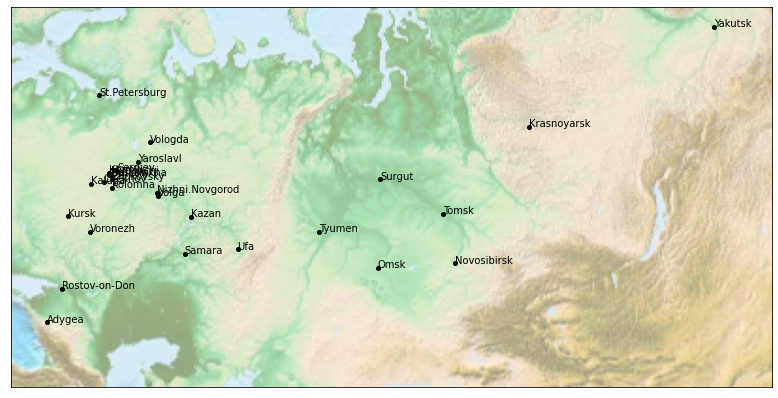

In [54]:
fig = plt.figure(figsize=(14, 7))
m = Basemap(projection='lcc', resolution=None,
            width=6E6, height=3E6, 
            lon_0=75, lat_0=60)

m.etopo(scale=0.5, alpha=0.5)

for index, row in cities.iterrows():
    city_name = row["city"]
    if city_name=="No-city": continue
    city_lat  = row["latitude"]
    city_lon  = row["longitude"]
    
    x, y = m(city_lon, city_lat) # Map (long, lat) to (x, y) for plotting
    plt.plot(x, y, 'ok', markersize=4)
    plt.text(x, y, city_name, fontsize=10);

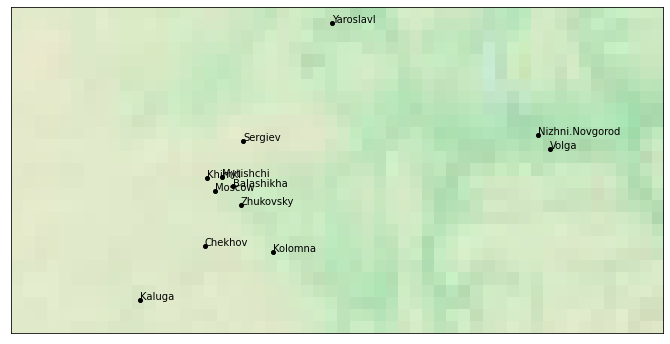

In [67]:
fig = plt.figure(figsize=(12, 6))
m = Basemap(projection='lcc', resolution=None,
            width=0.8E6, height=0.4E6, 
            lon_0=40, lat_0=56)

m.etopo(scale=0.5, alpha=0.5)

for index, row in cities.iterrows():
    city_name = row["city"]
    city_lat  = row["latitude"]
    city_lon  = row["longitude"]
    
    if city_name=="No-city": continue
    if city_lon<31 or 45<city_lon: continue
    if city_lat<54 or 59<city_lat: continue
    
    x, y = m(city_lon, city_lat) # Map (long, lat) to (x, y) for plotting
    plt.plot(x, y, 'ok', markersize=4)
    plt.text(x, y, city_name, fontsize=10);

### Shop type

In [8]:
shops['shop_type'] = 'regular'

#there is some overlap in tc and mall, mall is given precedence
shops.loc[shops['shop_name'].str.contains(r'tc'), 'shop_type'] = 'tc'
shops.loc[shops['shop_name'].str.contains(r'mall|center|mega'), 'shop_type'] = 'mall'
shops.loc[shops['shop_id'].isin([9,20]), 'shop_type'] = 'special'
shops.loc[shops['shop_id'].isin([12,55]), 'shop_type'] = 'online'

shops

,shop_name,shop_id,shop_city,shop_type
0,yakutsk ordzhonikidze - 56 francs,0,yakutsk,regular
1,yakutsk tc central fran,1,yakutsk,tc
2,adygea tc mega,2,adygea,mall
3,balashikha tc oktyabr-kinomir,3,balashikha,tc
4,volga tc volga mall,4,volga,mall
5,vologda sec marmelad,5,vologda,regular
6,voronezh (plekhanovskaya 13),6,voronezh,regular
7,voronezh sec maksimir,7,voronezh,regular
8,voronezh sec city-park grad,8,voronezh,regular
9,outbound trade,9,outbound,special


In [ ]:
shops['shop_name'] = shops['shop_name'].str.lower()
shops['shop_name'] = shops['shop_name'].str.replace(r'[^\w\d\s]', ' ')

### Training Dataframe (df)

In [4]:
df = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]]))))

df = pd.DataFrame(np.vstack(df), columns=['shop_id', 'item_id', 'date_block_num'])
df.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [142]:
sales_items = pd.merge(sales, items, on=['item_id'], how='left')
sales_items

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_name
0,02.01.2013,0,59,22154,999.00,1.0,37,SCENE 2012 (BD)
1,03.01.2013,0,25,2552,899.00,1.0,58,DEEP PURPLE The House Of Blue Light LP
2,05.01.2013,0,25,2552,899.00,-1.0,58,DEEP PURPLE The House Of Blue Light LP
3,06.01.2013,0,25,2554,1709.05,1.0,58,DEEP PURPLE Who Do You Think We Are LP
4,15.01.2013,0,25,2555,1099.00,1.0,56,DEEP PURPLE 30 Very Best Of 2CD (Businesses).
...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,55,V/A Nu Jazz Selection (digipack)
2935845,09.10.2015,33,25,7460,299.00,1.0,55,V/A The Golden Jazz Collection 1 2CD
2935846,14.10.2015,33,25,7459,349.00,1.0,55,V/A The Best Of The 3 Tenors
2935847,22.10.2015,33,25,7440,299.00,1.0,57,V/A Relax Collection Planet MP3 (mp3-CD) (jewel)


In [149]:


shop_cats   = sales_items.groupby(['item_category_id', 'shop_id']).agg({'item_cnt_day':'sum'}).unstack().fillna(0)

shop_cats

item_cnt_day                                            \
shop_id                    0      1      2      3      4      5      6    
item_category_id                                                          
0                         1.0    0.0    0.0    0.0    0.0    0.0    0.0   
1                         1.0    0.0    0.0    0.0    0.0    0.0    0.0   
2                       105.0   63.0  355.0  200.0  309.0  232.0  422.0   
3                        52.0   18.0  527.0  360.0  333.0  340.0  755.0   
4                        38.0   30.0   42.0   28.0  101.0   38.0   21.0   
...                       ...    ...    ...    ...    ...    ...    ...   
79                        0.0    0.0  222.0  252.0  501.0  309.0  639.0   
80                        0.0    0.0    0.0   99.0    5.0   26.0   62.0   
81                       44.0   28.0    2.0    0.0   31.0    0.0   52.0   
82                      146.0  169.0   70.0    0.0  380.0    0.0  608.0   
83                       86.0   64.0   51.0   56.0   70.0  120.0  693.0   

                                     ...                                       \
shop_id              7     8     9   ...     50      51     52     53      54   
item_category_id                     ...                                        
0                   0.0   0.0   0.0  ...    0.0     0.0    0.0    0.0     0.0   
1                   0.0   0.0   0.0  ...    0.0     0.0    0.0    0.0     0.0   
2                 491.0  19.0  32.0  ...  733.0   231.0  250.0  341.0   874.0   
3                 554.0   0.0  71.0  ...  773.0   247.0  376.0  460.0  1098.0   
4                  92.0   2.0   0.0  ...   92.0    56.0   55.0   68.0   103.0   
...                 ...   ...   ...  ...    ...     ...    ...    ...     ...   
79                689.0   1.0  14.0  ...  171.0     0.0  261.0  360.0   332.0   
80                 25.0   0.0   0.0  ...   13.0     0.0    2.0    8.0     0.0   
81                  0.0   0.0   0.0  ...    0.0   109.0   24.0    0.0    51.0   
82                  0.0   0.0   0.0  ...    0.0  1573.0  597.0    0.0   307.0   
83                145.0   0.0   0.0  ...  434.0   409.0  313.0  154.0   332.0   

                                                    
shop_id             55     56     57     58     59  
item_category_id                                    
0                  0.0    0.0    0.0    0.0    0.0  
1                  0.0    0.0    0.0    0.0    0.0  
2                  0.0  338.0  669.0  324.0  223.0  
3                  0.0  472.0  965.0  574.0  399.0  
4                  0.0   46.0  149.0   80.0   52.0  
...                ...    ...    ...    ...    ...  
79                 0.0  225.0  235.0  188.0  345.0  
80                12.0   81.0    0.0    0.0   30.0  
81                 0.0   47.0   81.0   36.0    0.0  
82                 0.0  792.0  628.0  411.0    0.0  
83                 0.0  272.0  610.0  260.0  534.0  

[84 rows x 60 columns]

In [150]:
shop_cats_norm = shop_cats / shop_cats.sum()

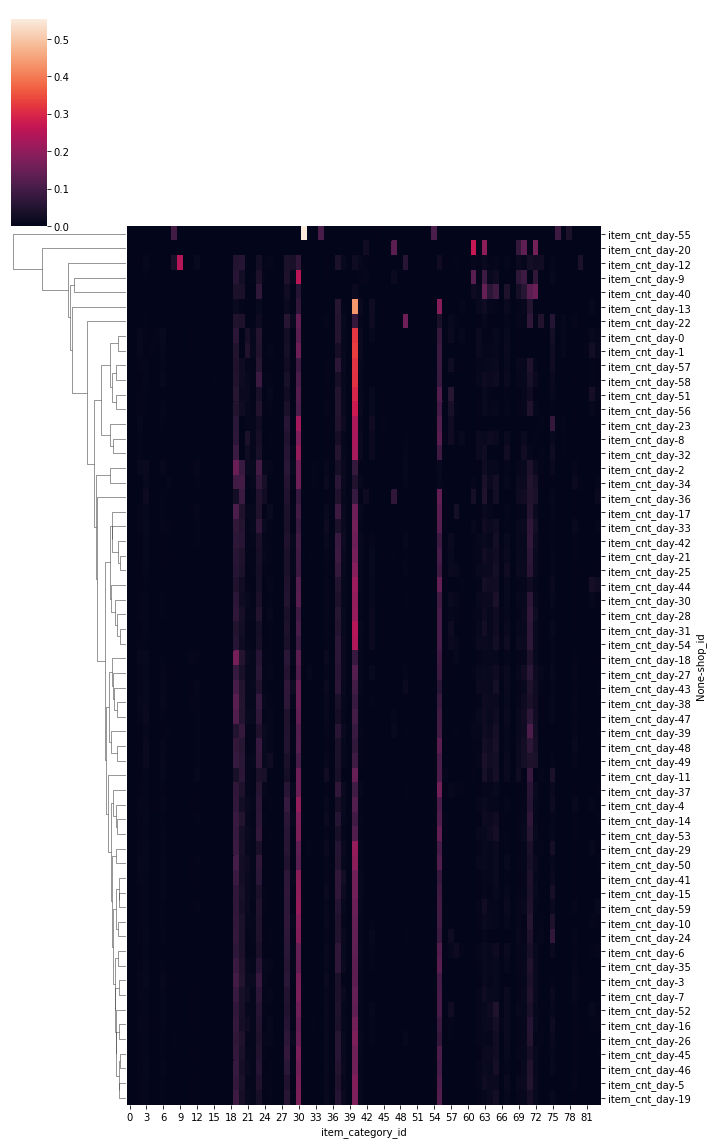

In [156]:
sb.clustermap(shop_cats_norm.T, col_cluster=False, figsize=(10, 16))

<AxesSubplot:xlabel='item_category_id', ylabel='None-shop_id'>

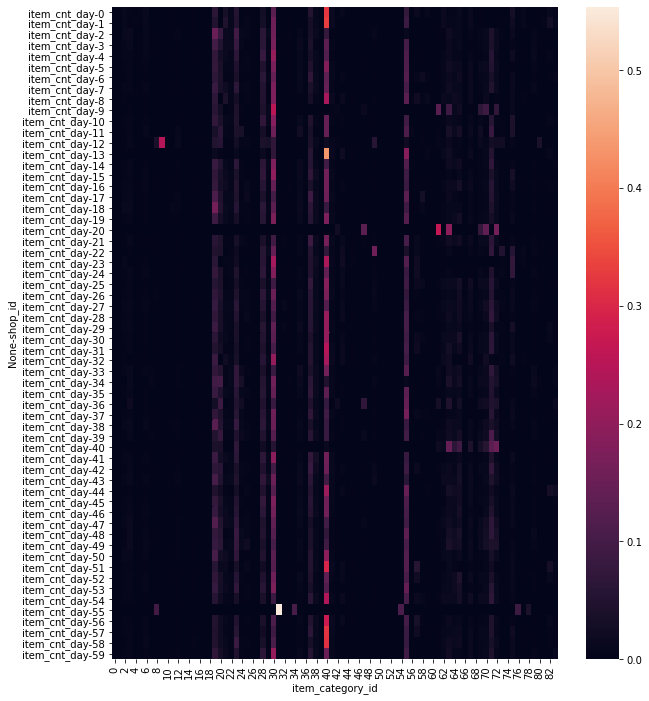

In [152]:
plt.figure(figsize=(10, 12))
sb.heatmap(shop_cats_norm.T)

In [62]:
shop_cats_norm

item_cnt_day                                          \
shop_id                    0         1         2         3         4    
item_category_id                                                        
0                    0.000085  0.000000  0.000000  0.000000  0.000000   
1                    0.000085  0.000000  0.000000  0.000000  0.000000   
2                    0.008971  0.009983  0.011594  0.007053  0.007032   
3                    0.004443  0.002852  0.017211  0.012696  0.007578   
4                    0.003246  0.004754  0.001372  0.000987  0.002298   
...                       ...       ...       ...       ...       ...   
79                   0.000000  0.000000  0.007250  0.008887  0.011401   
80                   0.000000  0.000000  0.000000  0.003491  0.000114   
81                   0.003759  0.004437  0.000065  0.000000  0.000705   
82                   0.012473  0.026779  0.002286  0.000000  0.008648   
83                   0.007347  0.010141  0.001666  0.001975  0.001593   

                                                                    ...  \
shop_id                 5         6         7         8         9   ...   
item_category_id                                                    ...   
0                 0.000000  0.000000  0.000000  0.000000  0.000000  ...   
1                 0.000000  0.000000  0.000000  0.000000  0.000000  ...   
2                 0.005425  0.004199  0.007322  0.005285  0.002017  ...   
3                 0.007951  0.007513  0.008262  0.000000  0.004475  ...   
4                 0.000889  0.000209  0.001372  0.000556  0.000000  ...   
...                    ...       ...       ...       ...       ...  ...   
79                0.007226  0.006359  0.010275  0.000278  0.000882  ...   
80                0.000608  0.000617  0.000373  0.000000  0.000000  ...   
81                0.000000  0.000517  0.000000  0.000000  0.000000  ...   
82                0.000000  0.006050  0.000000  0.000000  0.000000  ...   
83                0.002806  0.006896  0.002162  0.000000  0.000000  ...   

                                                                              \
shop_id                 50        51        52        53        54        55   
item_category_id                                                               
0                 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1                 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2                 0.009615  0.004737  0.005026  0.005531  0.004704  0.000000   
3                 0.010139  0.005065  0.007559  0.007461  0.005910  0.000000   
4                 0.001207  0.001148  0.001106  0.001103  0.000554  0.000000   
...                    ...       ...       ...       ...       ...       ...   
79                0.002243  0.000000  0.005247  0.005839  0.001787  0.000000   
80                0.000171  0.000000  0.000040  0.000130  0.000000  0.000189   
81                0.000000  0.002235  0.000482  0.000000  0.000275  0.000000   
82                0.000000  0.032255  0.012001  0.000000  0.001652  0.000000   
83                0.005693  0.008387  0.006292  0.002498  0.001787  0.000000   

                                                          
shop_id                 56        57        58        59  
item_category_id                                          
0                 0.000000  0.000000  0.000000  0.000000  
1                 0.000000  0.000000  0.000000  0.000000  
2                 0.004329  0.004741  0.003964  0.004552  
3                 0.006045  0.006839  0.007023  0.008144  
4                 0.000589  0.001056  0.000979  0.001061  
...                    ...       ...       ...       ...  
79                0.002882  0.001665  0.002300  0.007042  
80                0.001037  0.000000  0.000000  0.000612  
81                0.000602  0.000574  0.000440  0.000000  
82                0.010144  0.004451  0.005029  0.000000  
83                0.003484  0.004323  0.003181  0.01090

<AxesSubplot:>

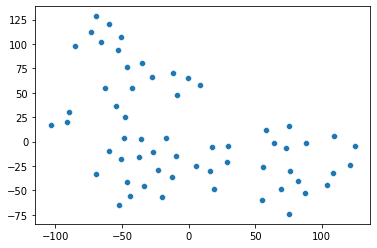

In [128]:
from sklearn.manifold import TSNE

shop_cats_tsne = TSNE(n_components=2, perplexity=10.0).fit_transform(shop_cats_norm.T)

sb.scatterplot(x=shop_cats_tsne[:,0], y=shop_cats_tsne[:,1])

<AxesSubplot:>

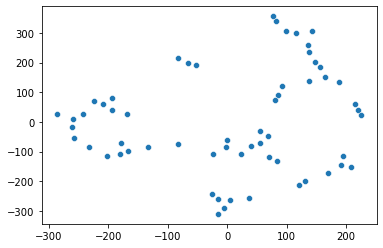

In [77]:
shops_cats = pd.DataFrame(
    np.array(list(product(*[shops['shop_id'].unique(), cats['item_category_id'].unique()]))),
    columns =['shop_id', 'item_category_id']
)

shops_cats

,shop_id,item_category_id
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
5035,59,79
5036,59,80
5037,59,81
5038,59,82


In [78]:
price = train[['item_id', 'item_price']]
price = price.groupby(['item_id'])['item_price'].mean().reset_index()
price

price

,item_id,item_price
0,0,58.000000
1,1,4490.000000
2,2,58.000000
3,3,79.000000
4,4,58.000000
...,...,...
21802,22165,59.000000
21803,22166,150.000000
21804,22167,297.686490
21805,22168,798.916667


In [7]:
shopprice = train[['shop_id', 'item_id', 'item_price']]
shopprice = shopprice.groupby(['item_id', 'shop_id'])['item_price'].mean().reset_index()
shopprice

,item_id,shop_id,item_price
0,0,54,58.0
1,1,55,4490.0
2,2,54,58.0
3,3,54,79.0
4,4,54,58.0
...,...,...,...
424119,22168,12,799.0
424120,22168,16,799.0
424121,22168,42,799.0
424122,22168,43,798.5


In [15]:
testtmp = test.merge(shopprice, on=['item_id', 'shop_id'], how='left')
testtmp

,shop_id,item_id,item_price
0,5,5037,1633.692308
1,5,5320,NaN
2,5,5233,865.666667
3,5,5232,599.000000
4,5,5268,NaN
...,...,...,...
214195,45,18454,187.888889
214196,45,16188,NaN
214197,45,15757,199.000000
214198,45,19648,NaN


In [ ]:
testtmp.loc[testtmp['item_price'].isnull(), 'item_price'] = df['Pclass'].map(price.item_price)

In [24]:
price.head()

,item_id,item_price
0,0,58.0
1,1,4490.0
2,2,58.0
3,3,79.0
4,4,58.0


In [ ]:
#testtmp = testtmp[cond]

In [8]:
df = pd.DataFrame([1,2,3,4], columns=["s"])
df

,s
0,1
1,2
2,3
3,4


In [10]:
df2 = df
df2.

,s
0,1
1,2
2,3
3,4


In [13]:
df2.iloc[0, 0] = 99
df2

,s
0,99
1,2
2,3
3,4


In [16]:
df

,s
0,99
1,2
2,3
3,4


0    99
Name: s, dtype: int64

In [21]:
#df3 = df[df.s > 10]
df3 = df.loc[df.s > 10, 's']

df3

0    99
Name: s, dtype: int64

In [22]:
df3[0] = 88

In [23]:
df

,s
0,99
1,2
2,3
3,4
